# Implementation of U-Net architecture for Pascal VOC 2012 dataset

U-Net: Convolutional Networks for Biomedical Image Segmentation
Olaf Ronneberger, Philipp Fischer, Thomas Brox
https://arxiv.org/abs/1505.04597

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image

In [2]:
IMAGE_SIZE = 224

# Data exploration

In [5]:
transforms = v2.Resize((IMAGE_SIZE, IMAGE_SIZE))
data = VOCSegmentation("data", image_set="trainval", download=True, transforms=transforms)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [6]:
image, mask = data[0]

In [7]:
def overlay_mask(image, mask):
    return Image.blend(image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

In [8]:
def show_random_images(data, num_to_display, with_mask=True):
    for idx in np.random.randint(0, 2000, num_to_display):
        image, mask = data[idx]
        plt.figure()
        plt.axis("off")
        if with_mask:
            plt.imshow(overlay_mask(image, mask))
        else:
            plt.imshow(image)

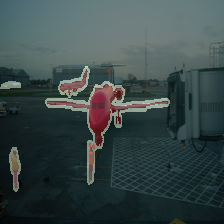

In [9]:
overlay_mask(image, mask)

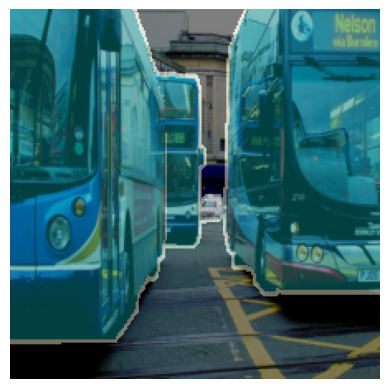

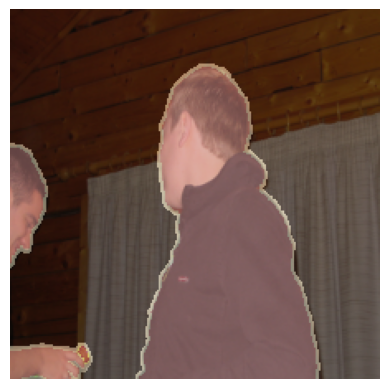

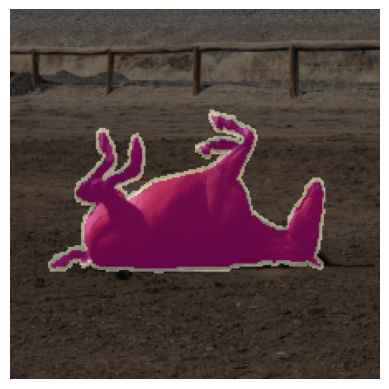

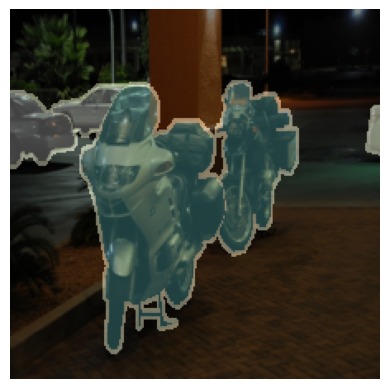

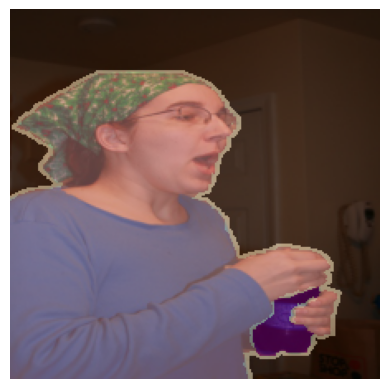

In [10]:
show_random_images(data, 5)

# Loading training and validation data

In [26]:
image_tfs = v2.Compose([v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                        v2.ToImage(),
                        v2.ToDtype(dtype=torch.float32, scale=True),
                        # v2.ColorJitter(),
                        # v2.ElasticTransform()
                       ])
mask_tfs = v2.Compose([v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                       v2.ToImage(),
                       ])
data = VOCSegmentation("data", image_set="trainval", download=True, transform=image_tfs, target_transform=mask_tfs) 

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [27]:
data[0][0].shape

torch.Size([3, 224, 224])

# Building the model

Note: the model is downscaled due to rescaling images to 224x224. 4 maxpools as described in the paper would lead to the last downsampling layer having 1024 channels with 4x4 resolution which seemed to make little sense.

In [165]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        
        def ConvStack(in_channels, out_channels):
            return nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3)
                )
            
        self.conv = ConvStack(in_channels, out_channels) 
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return out

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64):
        super().__init__()
        self.up_conv = nn.up_conv()
    


         
class UNetEncoder(nn.Module):
    def __init__(self, init_out_channels=64):
        super().__init__()
        self.out_channels = init_out_channels
        # 224 -> 222 -> 220 -> 110 (max pool) 
        self.conv64 = UNetEncoderBlock(in_channels=3, out_channels=self.out_channels)
        self.maxpool64 = nn.MaxPool2d(2)
        
        # 110 -> 53
        self.conv128 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels)
        self.maxpool128 = nn.MaxPool2d(2)
        self.out_channels *= 2
        
        
        # 53 -> 51 -> 49 -> (padding) 25 
        self.conv256 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels)
        self.maxpool256 = nn.MaxPool2d(2, padding=1)
        self.out_channels *= 2
                
        # 25 -> 23 -> 21
        self.conv512 = UNetEncoderBlock(in_channels=self.out_channels, out_channels=2 * self.out_channels)
        self.out_channels *= 2

        # 21 -> 22
        self.upconv256 = nn.ConvTranspose2d(in_channels=self.out_channels, out_channels=self.out_channels // 2, kernel_size=2, stride=2)
                    
    def forward(self, x):
        out64 = self.conv64(x)
        out = self.maxpool64(out64)
        
        out128 = self.conv128(out)
        out = self.maxpool128(out128)
        
        out256 = self.conv256(out)
        out = self.maxpool256(out256)
        
        out = self.conv512(out)
        out = self.upconv256(out)
        out256 = v2.CenterCrop((out.shape[2], out.shape[3]))(out256)
        out = torch.cat([out, out256], dim=1)
        return out

In [166]:
encoder = UNetEncoder()

In [167]:
example = data[0][0][None, :]

In [168]:
example_encoded = encoder(example)

In [169]:
example_encoded.shape

torch.Size([1, 512, 42, 42])

In [150]:
mpool_test = torch.rand((1, 3, 3))
mpool_test

tensor([[[0.9268, 0.4200, 0.4533],
         [0.0561, 0.7420, 0.7690],
         [0.1309, 0.0118, 0.9584]]])

In [98]:
nn.MaxPool2d(2, padding=1)(mpool_test)

tensor([[[0.3286, 0.6340],
         [0.4753, 0.5788]]])

In [139]:
upconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, padding=0)

In [143]:
upconv_test = torch.rand((1, 1, 2, 2))
upconv_test

tensor([[[[0.1074, 0.7173],
          [0.5960, 0.3281]]]])

In [144]:
upconv(upconv_test)

tensor([[[[-0.1492, -0.3579, -0.2853],
          [-0.2482,  0.0079,  0.0905],
          [ 0.1497,  0.2662,  0.0132]]]], grad_fn=<ConvolutionBackward0>)

In [142]:
upconv(upconv_test).shape

torch.Size([1, 1, 2, 2])

In [ ]:
nn.Upsample()